# Lab 07:  Decision Trees



#### Part 1

Train and fine tune a decision tree for the moons dataset  
* Use make_moons(n_samples=10000, noise=0.4) to generate a moons dataset
* Use train_test_split() to split the dataset into a training set and a test set.
* Use grid search with cross-validation (with the help of the GridSearchCV
class) to find good hyperparameter values for a DecisionTreeClassifier.
Hint: try various values for max_leaf_nodes.
* Train it on the full training set using these hyperparameters, and measure
your model’s performance on the test set. You should get roughly 85% to 87%
accuracy.

currently performing grid search
Fitting 5 folds for each of 150 candidates, totalling 750 fits

most optimal parameters: {'max_depth': None, 'max_leaf_nodes': 25, 'min_samples_split': 2}
highest cross val score: 0.859

accuracy of test set: 0.872

report of classification:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1013
           1       0.86      0.88      0.87       987

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



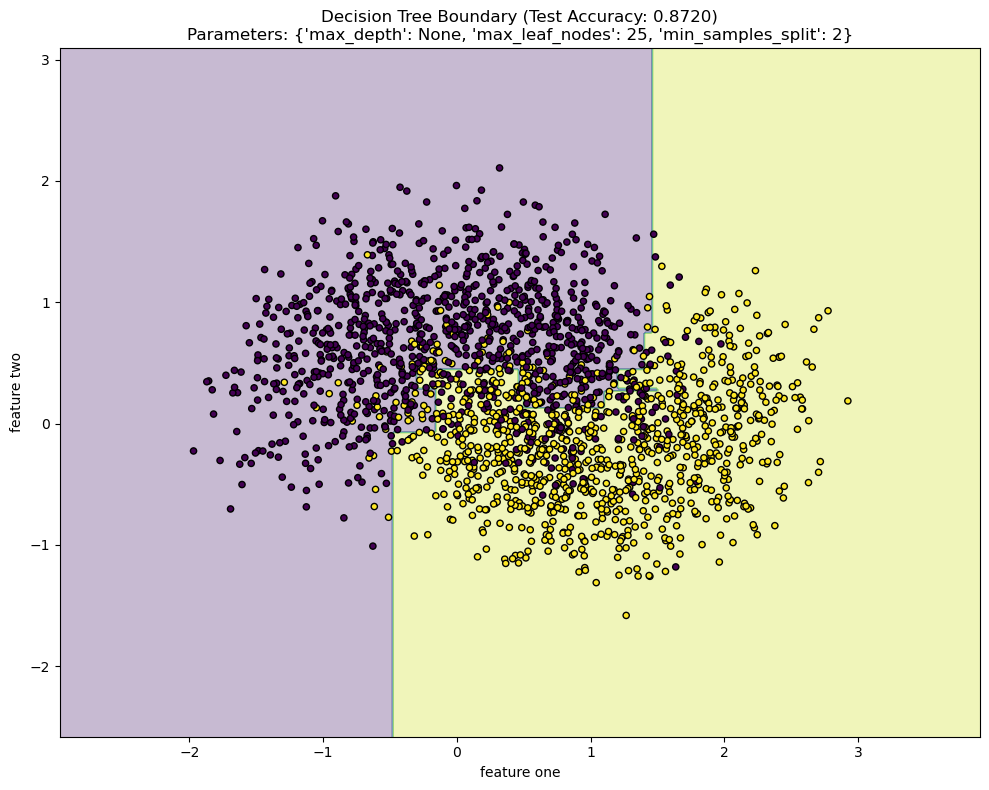

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# sets random seed
np.random.seed(42)

#  generates moon datast with 10,000 samples and 0.4 noise
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

#  splits into training and test set 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# grid search w/ cross validation to get best parameters 
param_grid = {
    'max_leaf_nodes': [5, 10, 15, 20, 25, 30, 40, 50, 100, 200],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

# creates decision tree classifier
tree_clf = DecisionTreeClassifier(random_state=42)

# grid search w/ 5 fold validation 
grid_search = GridSearchCV(
    tree_clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# performs grid search
print("currently performing grid search")
grid_search.fit(X_train, y_train)

# prints best parameters and scores
print("\nmost optimal parameters:", grid_search.best_params_)
print("highest cross val score:", grid_search.best_score_)

# train new model w/ best paramaters on full training set 
best_tree_clf = DecisionTreeClassifier(**grid_search.best_params_, random_state=42)
best_tree_clf.fit(X_train, y_train)

# evaluate model on test set
y_pred = best_tree_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\naccuracy of test set:", accuracy)
print("\nreport of classification:")
print(classification_report(y_test, y_pred))

#  visualizes the decision boundary
def plot_decision_boundary(clf, X, y, title):
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=20)
    plt.title(title)
    plt.xlabel('feature one')
    plt.ylabel('feature two')
    plt.tight_layout()
    plt.show()

# plots decision boundary of best of best model
plot_decision_boundary(best_tree_clf, X_test, y_test, 
                      f"Decision Tree Boundary (Test Accuracy: {accuracy:.4f})\nParameters: {grid_search.best_params_}")

#### Part 2: Grow a forest by following these steps:

* Continuing the previous exercise, generate 1,000 subsets of the training set,
each containing 100 instances selected randomly. Hint: you can use Scikit-
Learn’s ShuffleSplit class for this.
* Train one Decision Tree on each subset, using the best hyperparameter values
found in the previous exercise. Evaluate these 1,000 Decision Trees on the test
set. Since they were trained on smaller sets, these Decision Trees will likely
perform worse than the first Decision Tree, achieving only about 80%
accuracy.
* Now comes the magic. For each test set instance, generate the predictions of
the 1,000 Decision Trees, and keep only the most frequent prediction (you can
use SciPy’s mode() function for this). This approach gives you majority-vote
predictions over the test set.
* Evaluate these predictions on the test set: you should obtain a slightly higher
accuracy than your first model (about 0.5 to 1.5% higher). Congratulations,
you have trained a Random Forest classifier!

In [13]:
from scipy import stats
from sklearn.model_selection import ShuffleSplit


print("\ncurrently generating 1,000 subsets of the training set!")
n_subsets = 1000
subset_size = 100
shuffle_split = ShuffleSplit(n_splits=n_subsets, test_size=None, train_size=subset_size, random_state=42)

# trains one decision tree on every subset using best hyperparameters
print("training 1,000 decision trees on the subsets currently!")
predictions = np.zeros((n_subsets, len(X_test)))

for i, (train_index, _) in enumerate(shuffle_split.split(X_train)):
    # gets subset
    X_subset = X_train[train_index]
    y_subset = y_train[train_index]
    
    # trains tree with most optimal parameters
    tree = DecisionTreeClassifier(**grid_search.best_params_, random_state=i)
    tree.fit(X_subset, y_subset)
    
    # makes predicions on test set
    predictions[i] = tree.predict(X_test)
    
    # prints progress of 100 trees
    if (i + 1) % 100 == 0:
        print(f"Trained {i + 1}/{n_subsets} trees")

# average accuracy of indivudal tree
individual_accuracies = [accuracy_score(y_test, predictions[i]) for i in range(n_subsets)]
avg_accuracy = np.mean(individual_accuracies)
print(f"\nhere is the average acuracy of every tree: {avg_accuracy:.4f}")

# generates majority vote predictions
print("getting majority vote predictions.")
ensemble_predictions = stats.mode(predictions, axis=0, keepdims=False)[0]

# evaluates ensemble prediction 
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print(f"Ensemble accuracy (majority voting): {ensemble_accuracy:.4f}")



currently generating 1,000 subsets of the training set!
training 1,000 decision trees on the subsets currently!
Trained 100/1000 trees
Trained 200/1000 trees
Trained 300/1000 trees
Trained 400/1000 trees
Trained 500/1000 trees
Trained 600/1000 trees
Trained 700/1000 trees
Trained 800/1000 trees
Trained 900/1000 trees
Trained 1000/1000 trees

here is the average acuracy of every tree: 0.7978
getting majority vote predictions.
Ensemble accuracy (majority voting): 0.8720
